# inportant

In [6]:
from keras.callbacks import EarlyStopping
from keras.layers.advanced_activations import ReLU
from keras.layers.core import Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
from keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from keras.utils import np_utils


class NNClassifier:
    '''
    Usage:
    clf = NNClassifier(**params)
    history = clf.fit(
    X_train,
    y_train,
    X_valid,
    y_valid,
    early_stopping_rounds
    )
    '''
    
    def __init__(self, input_shape=1024, input_dropout=0.2, hidden_layers=1, hidden_units=64, hidden_dropout=0.2,
                 batch_norm="none", learning_rate=0.05, batch_size=64, epochs=10000):
        self.input_shape = int(input_shape) # layer param
        self.input_dropout = input_dropout # layer param
        self.hidden_layers = int(hidden_layers) # layer param
        self.hidden_units = int(hidden_units) # layer param
        self.hidden_dropout = hidden_dropout # layer param
        self.batch_norm = batch_norm # layer param
        self.learning_rate = learning_rate # optimizer param
        self.batch_size = int(batch_size) # fit param
        self.epochs = int(epochs) # fit param
        
    def fit(self, X_train, y_train, X_valid, y_valid, early_stopping_rounds):
        # Data standardization
        self.scaler = StandardScaler()
        X_train = self.scaler.fit_transform(X_train)
        X_valid = self.scaler.transform(X_valid)
        # layers
        self.model = Sequential()
        self.model.add(Dropout(self.input_dropout, input_shape=(self.input_shape,)))
        for i in range(self.hidden_layers):
            self.model.add(Dense(self.hidden_units))
            if self.batch_norm == 'before_act':
                self. model.add(BatchNormalization())
            else:
                raise NotImplementedError
            self.model.add(ReLU())
            self.model.add(Dropout(self.hidden_dropout))
        self.model.add(Dense(1, activation='sigmoid'))
        # Optimazer
        optimizer = Adam(lr=self.learning_rate, beta_1=0.9, beta_2=0.999, decay=0.)
        # Compile
        self.model.compile(
            loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy']
        )
        # train
        early_stopping = EarlyStopping(patience=early_stopping_rounds, restore_best_weights=True)
        self.history = self.model.fit(
            X_train,
            y_train,
            epochs=self.epochs,
            batch_size=self.batch_size,
            verbose=1,
            validation_data=(X_valid, y_valid),
            callbacks=[early_stopping]
        )
        return self.history
    
    def predict(self, x):
        x = self.scaler.transform(x)
        y_pred = self.model.predict(x)
        y_pred = y_pred.flatten()
        return y_pred

    def get_model(self):
        return self.model

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer
brest_c = load_breast_cancer()
X = brest_c['data']
y = brest_c['target']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

# input_shape = X.shape[1]
# input_dropout = 0.0
# hidden_layers = 1
# hidden_units = 16
# hidden_dropout = 0.2
# batch_norm = 'before_act'
# batch_size = 10
# learning_rate = 0.05
# epochs = 10000
early_stopping_rounds = 10

params = {
    'input_shape':X.shape[1],
    "input_dropout":0.0,
    "hidden_layers":1,
    'hidden_units':16,
    'hidden_dropout':0.2,
    'batch_norm':'before_act',
    'batch_size':10,
    'learning_rate':0.05,
    'epochs':10000
}


model = NNClassifier(
    **params
#     input_shape, input_dropout, hidden_layers, hidden_units, hidden_dropout,
#                  batch_norm, learning_rate, batch_size, epochs
)
hist = model.fit(
    X_train,
    y_train,
    X_valid,
    y_valid,
    early_stopping_rounds
)

Train on 455 samples, validate on 114 samples
Epoch 1/10000
455/455 [==============================] - 0s 805us/step - loss: 0.2310 - accuracy: 0.9253 - val_loss: 0.0617 - val_accuracy: 0.9737
Epoch 2/10000
455/455 [==============================] - 0s 143us/step - loss: 0.2068 - accuracy: 0.9297 - val_loss: 0.0539 - val_accuracy: 0.9912
Epoch 3/10000
455/455 [==============================] - 0s 133us/step - loss: 0.1703 - accuracy: 0.9429 - val_loss: 0.0794 - val_accuracy: 0.9649
Epoch 4/10000
455/455 [==============================] - 0s 127us/step - loss: 0.2296 - accuracy: 0.9121 - val_loss: 0.1007 - val_accuracy: 0.9825
Epoch 5/10000
455/455 [==============================] - 0s 141us/step - loss: 0.2242 - accuracy: 0.9341 - val_loss: 0.1266 - val_accuracy: 0.9825
Epoch 6/10000
455/455 [==============================] - 0s 136us/step - loss: 0.2249 - accuracy: 0.9033 - val_loss: 0.1314 - val_accuracy: 0.9474
Epoch 7/10000
455/455 [==============================] - 0s 141us/step -

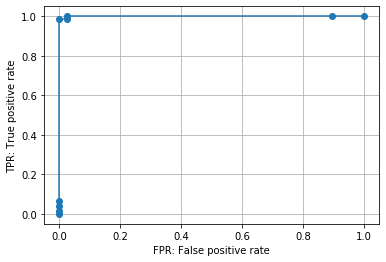

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_valid, model.predict(X_valid))
plt.plot(fpr, tpr, marker='o')
plt.xlabel('FPR: False positive rate')
plt.ylabel('TPR: True positive rate')
plt.grid()

# Trainerクラスの編集

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


class Trainer:

    '''
    # Usage
    n_splits = 3
    random_state = 0
    early_stopping_rounds=10
    kf = KFold(n_splits=n_splits, random_state=random_state, shuffle=True)
    for tr_idx, va_idx in kf.split(X, y):
        model = Trainer(XGBRegressor(**XGB_PARAMS))
        model.fit(
            X[tr_idx],
            y[tr_idx],
            X[va_idx],
            y[va_idx],
            early_stopping_rounds
        )
        model.get_learning_curve()
    '''

    def __init__(self, model):
        self.model = model
        self.model_type = type(model).__name__
        self.best_iteration = 100
        self.train_rmse = []
        self.valid_rmse = []
        self.importance = []

    
    def fit(self,
            X_train, y_train, X_valid, y_valid,
            early_stopping_rounds):

        eval_set = [(X_train, y_train), (X_valid, y_valid)]

        if self.model_type == "LGBMClassifier":
            self.model.fit(
                X_train,
                y_train,
                early_stopping_rounds=early_stopping_rounds,
                eval_set=eval_set,
                eval_metric='logloss',
                verbose=False
            )
            self.best_iteration = self.model.best_iteration_
            self.importance = self.model.booster_.feature_importance(
                importance_type='gain')
            self.train_logloss = np.array(
                self.model.evals_result_['training']['binary_logloss'])
            self.valid_logloss = np.array(
                self.model.evals_result_['valid_1']['binary_logloss'])
            self.importance = self.model.feature_importances_

        elif self.model_type == 'XGBClassifier':
            self.model.fit(
                X_train,
                y_train,
                early_stopping_rounds=early_stopping_rounds,
                eval_set=eval_set,
                eval_metric='logloss',
                verbose=0
            )
            self.best_iteration = self.model.best_iteration
            self.importance = self.model.feature_importances_
            self.train_logloss = np.array(
                self.model.evals_result_['validation_0']['logloss'])
            self.valid_logloss = np.array(
                self.model.evals_result_['validation_1']['logloss'])
            
        elif self.model_type == 'NNClassifier':
            self.history = self.model.fit(
                X_train,
                y_train,
                X_valid,
                y_valid,
                early_stopping_rounds
            )
            self.train_logloss = np.array(self.history.history['loss'])
            self.valid_logloss = np.array(self.history.history['val_loss'])
            

    def predict_proba(self, X):
        if self.model_type == "LGBMClassifier":
            print(print(f"model type is {self.model_type}"))
            return self.model.predict_proba(X, ntree_limit=self.best_iteration)
        elif self.model_type == "XGBClassifier":
            print(print(f"model type is {self.model_type}"))
            return self.model.predict_proba(X, ntree_limit=self.best_iteration)
        elif self.model_type == 'NNClassifier':
            print(print(f"model type is {self.model_type}"))
            return self.model.predict(X)
        
        
    def get_model(self):
        if self.model_type == "LGBMClassifier":
            print(print(f"model type is {self.model_type}"))
            return self.model
        elif self.model_type == "XGBClassifier":
            print(print(f"model type is {self.model_type}"))
            return self.model
        elif self.model_type == 'NNClassifier':
            return self.model.get_model()

    
    def get_best_iteration(self):
        print(print(f"model type is {self.model_type}"))
        return self.best_iteration

    
    def get_importance(self):
        if self.model_type == "LGBMClassifier":
            print(print(f"model type is {self.model_type}"))
            return self.importance
        elif self.model_type == "XGBClassifier":
            print(print(f"model type is {self.model_type}"))
            return self.importance
        elif self.model_type == 'NNClassifier':
            print(print(f"model type is {self.model_type}"))
            return 'For NNClassifier, feature importance is not callable.'

        
    def get_learning_curve(self):
        palette = sns.diverging_palette(220, 20, n=2)
        width = np.arange(self.train_logloss.shape[0])
        plt.figure(figsize=(10, 7.32))
        plt.title(
            'Learning_Curve ({})'.format(self.model_type), fontsize=15)
        plt.xlabel('Iterations', fontsize=15)
        plt.ylabel('LogLoss', fontsize=15)
        plt.plot(width, self.train_logloss, label='train_logloss', color=palette[0])
        plt.plot(width, self.valid_logloss, label='valid_logloss', color=palette[1])
        plt.legend(loc='upper right', fontsize=13)
        plt.show()

In [21]:
early_stopping_rounds = 10
params = {
    'input_shape':X.shape[1],
    "input_dropout":0.0,
    "hidden_layers":1,
    'hidden_units':16,
    'hidden_dropout':0.2,
    'batch_norm':'before_act',
    'batch_size':10,
    'learning_rate':0.05,
    'epochs':10000
}

clf = Trainer(NNClassifier(**params))
clf.fit(
    X_train,
    y_train,
    X_valid,
    y_valid,
    early_stopping_rounds
)

Train on 455 samples, validate on 114 samples
Epoch 1/10000
455/455 [==============================] - 0s 906us/step - loss: 0.2766 - accuracy: 0.8945 - val_loss: 0.0816 - val_accuracy: 0.9474
Epoch 2/10000
455/455 [==============================] - 0s 141us/step - loss: 0.1923 - accuracy: 0.9319 - val_loss: 0.1044 - val_accuracy: 0.9737
Epoch 3/10000
455/455 [==============================] - 0s 137us/step - loss: 0.2212 - accuracy: 0.9209 - val_loss: 0.1053 - val_accuracy: 0.9649
Epoch 4/10000
455/455 [==============================] - 0s 138us/step - loss: 0.2421 - accuracy: 0.9077 - val_loss: 0.1054 - val_accuracy: 0.9737
Epoch 5/10000
455/455 [==============================] - 0s 136us/step - loss: 0.1711 - accuracy: 0.9363 - val_loss: 0.1751 - val_accuracy: 0.9386
Epoch 6/10000
455/455 [==============================] - 0s 137us/step - loss: 0.1292 - accuracy: 0.9495 - val_loss: 0.0831 - val_accuracy: 0.9737
Epoch 7/10000
455/455 [==============================] - 0s 137us/step -

In [22]:
clf.predict_proba(X_valid)

model type is NNClassifier
None


array([9.9940646e-01, 9.9535847e-01, 9.9583560e-01, 9.9998462e-01,
       9.8806548e-01, 6.5216422e-03, 3.1668842e-01, 3.3468008e-05,
       9.9999601e-01, 2.5033951e-06, 9.9955010e-01, 9.9984199e-01,
       9.7854650e-01, 1.1622906e-06, 9.9643040e-01, 8.7002069e-02,
       9.9999899e-01, 9.9293202e-01, 9.9998802e-01, 9.5029396e-01,
       9.6288007e-01, 9.6048498e-01, 9.2511106e-01, 6.3275397e-03,
       9.9450684e-01, 9.9405301e-01, 5.2212292e-01, 4.4408613e-01,
       9.9989408e-01, 9.9989676e-01, 9.9943984e-01, 5.2930415e-03,
       9.9664992e-01, 5.9879124e-03, 9.9999923e-01, 9.9998236e-01,
       2.3837507e-02, 9.9987662e-01, 5.1377881e-01, 0.0000000e+00,
       9.9960327e-01, 1.0412335e-03, 9.9757081e-01, 8.1435275e-01,
       1.0934472e-04, 9.9679434e-01, 6.2029660e-01, 6.7865229e-01,
       1.0132790e-06, 9.9969822e-01, 9.9875641e-01, 9.9999666e-01,
       4.6187639e-04, 9.9864727e-01, 6.5717101e-04, 9.9972618e-01,
       7.1910918e-03, 9.9856848e-01, 9.9999219e-01, 9.9684918e

In [23]:
clf.get_best_iteration()

model type is NNClassifier
None


100

In [24]:
clf.get_importance()

model type is NNClassifier
None


'For NNClassifier, feature importance is not callable.'

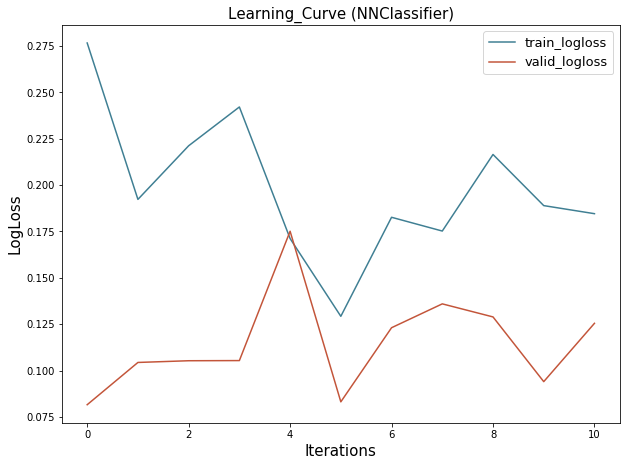

In [25]:
clf.get_learning_curve()

In [26]:
m = clf.get_model()
m.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_7 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 16)                496       
_________________________________________________________________
batch_normalization_4 (Batch (None, 16)                64        
_________________________________________________________________
re_lu_4 (ReLU)               (None, 16)                0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 17        
Total params: 577
Trainable params: 545
Non-trainable params: 32
_______________________________________________________

In [28]:
clf.history.history[]

{'val_loss': [0.08158592647350017,
  0.10436565004975389,
  0.10528957497393876,
  0.10537468772708324,
  0.1750935291454784,
  0.08313599774785536,
  0.12308569013941706,
  0.13594471521495857,
  0.12890344493810021,
  0.09402357361671564,
  0.12546090876454846],
 'val_accuracy': [0.9473684430122375,
  0.9736841917037964,
  0.9649122953414917,
  0.9736841917037964,
  0.9385964870452881,
  0.9736841917037964,
  0.9561403393745422,
  0.9561403393745422,
  0.9736841917037964,
  0.9736841917037964,
  0.9649122953414917],
 'loss': [0.2765693956842789,
  0.19225488277663896,
  0.22115275202380433,
  0.24207175482105422,
  0.17114570583370362,
  0.12923548758480247,
  0.18261174501462296,
  0.17519613216211508,
  0.2164686496809616,
  0.18890566833235406,
  0.18455428111233882],
 'accuracy': [0.8945055,
  0.93186814,
  0.9208791,
  0.9076923,
  0.93626374,
  0.94945055,
  0.93186814,
  0.94065934,
  0.9230769,
  0.93846154,
  0.94065934]}